# **RANDOM FOREST CLASSIFICATION <br>WITH HYPERPARAMETER TUNING**

# 
**Random Forest Classification** is a supervised machine learning algorithm. 

**Supervised Learning** is a subclass of machine learning that uses *labeled data* to learn and search for patterns in the input data that correlate with the correct output label. 

The objective of a **classification algorithm** is to assign input data to a specific class or label. 

Real life applications are spam detection, or predictive analysis to help predict a certain outcome (e.g. disease diagnosis). 

<sup><sub>Sources: [towardsdatascience](https://towardsdatascience.com/a-brief-introduction-to-supervised-learning-54a3e3932590), [IBM](https://www.ibm.com/topics/supervised-learning)</sub></sup>

# 
## How does Random Forest Work ?

To explain how the ***Random Forest Classification (RFC)*** algorithm works we need to first explain how ***decision trees*** work as this is the basis of RFC.

# 
#### Decision Trees

A decision tree consists of `nodes` and `branches`. In the simplest form, ***each node has a condition*** that splits the data into branches. The ***goal is to get a leaf node*** or pure node where only one class of the data is present.

Choosing a condition to split the data is not always trivial though. This is why the model tries to maximise the ***information gain*** for each node. To evaluate the information-gain one can calculate the ***Entropy*** or Gini index.

<br>

![alt text](https://miro.medium.com/v2/resize:fit:720/format:webp/1*3P1333UmqEww6YMpjisj4Q.png "Decision Tree Structure")

<sup><sub>Source: [medium.com](https://towardsdatascience.com/decision-trees-explained-3ec41632ceb6)</sub></sup>

# 
#### Random Forest Classification

As the name now suggests, ***Random Forest Classification consist of many individual trees*** that work together to get a less a biased prediction. To determine a class the algorithm uses ***majority voting***. Each tree makes predictions for a given instance, and the final result is determined by selecting the class with the highest number of votes among the trees.

<br>

![alt text](https://miro.medium.com/v2/resize:fit:640/format:webp/1*VHDtVaDPNepRglIAv72BFg.jpeg  "Majority Voting")

<sup><sub>Source: [towardsdatascience](https://towardsdatascience.com/understanding-random-forest-58381e0602d2 )</sub></sup>

# 
##### **Tackling over-fitting**
Using many trees reduces the influence of the error of each tree. This tackles the issue of the Decision Tree algorithm which tends to overfit on the training data.
<br>

##### **Bagging**
To further reduce the sensitivity to the training data, we employ a technique known as ***bootstrapping***. This approach involves taking the initial dataset and generating multiple simulated datasets by resampling (with replacement) from it. Each tree is then constructed using one of these newly generated and sampled datasets. ***Combining bootstrapping with the aggregation*** of individual predictions is also known as ***bagging***.
<br>

##### **Random Features**
Trees exhibiting strong correlation tend to behave similarly, which can lead to similar errors. ***Random feature selection*** helps maintain the diversity and effectiveness of the tree ensemble, by taking only a certain number of random features from the bootstrapped data sets instead of using all of them. 


# 
## 0. Importing Libraries

`MAX_TIME` determines the maximum amount of time the optimiser runs for after creating the initial models. 

`INIT_SIZE` controls how many initial models will be evaluated before building a surrogate and optimising. 

In [1]:
MAX_TIME = 10 # Time in minutes. Counter starts, after the initial design is evaluated. So, runtime can be larger.
INIT_SIZE = 50 # Initial number of designs to evaluate, before the surrogate is build.

In [2]:
import socket
import os
from datetime import datetime
from dateutil.tz import tzlocal
start_time = datetime.now(tzlocal())
HOSTNAME = socket.gethostname().split(".")[0]
experiment_name = '16-sklearnRandomForestClassifier' + "_" + HOSTNAME + "_" + str(MAX_TIME) + "min_" + str(INIT_SIZE) + "init_" + str(start_time).split(".", 1)[0].replace(' ', '_')
experiment_name = experiment_name.replace(':', '-')
print(experiment_name)
if not os.path.exists('./figures'):
    os.makedirs('./figures')

16-sklearnRandomForestClassifier_nomad_10min_50init_2023-07-15_19-52-38


In [3]:
pip list | grep  "spot[RiverPython]"

Note: you may need to restart the kernel to use updated packages.


'grep' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
from tabulate import tabulate
import warnings
import numpy as np
from math import inf
import pandas as pd

from scipy.optimize import differential_evolution

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder , MinMaxScaler, StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline , Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_absolute_error, accuracy_score, roc_curve, roc_auc_score, log_loss, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import top_k_accuracy_score

warnings.filterwarnings("ignore")

from spotPython.spot import spot
from spotPython.hyperparameters.values import (
    add_core_model_to_fun_control,
    assign_values,
    convert_keys,
    get_bound_values,
    get_default_hyperparameters_for_core_model,
    get_default_values,
    get_default_hyperparameters_as_array,
    get_dict_with_levels_and_types,
    get_values_from_dict,
    get_var_name,
    get_var_type,
    iterate_dict_values,
    modify_hyper_parameter_levels,
    modify_hyper_parameter_bounds,
    replace_levels_with_positions,
    return_conf_list_from_var_dict,
    get_one_core_model_from_X,
    transform_hyper_parameter_values,
    get_dict_with_levels_and_types,
    convert_keys,
    iterate_dict_values,
    get_one_sklearn_model_from_X
)

from spotPython.utils.convert import class_for_name
from spotPython.utils.eda import (
    get_stars,
    gen_design_table)
from spotPython.utils.transform import transform_hyper_parameter_values
from spotPython.utils.convert import get_Xy_from_df
from spotPython.plot.validation import plot_cv_predictions, plot_roc, plot_confusion_matrix
from spotPython.utils.init import fun_control_init

from spotPython.data.sklearn_hyper_dict import SklearnHyperDict
from spotPython.fun.hypersklearn import HyperSklearn
from spotPython.utils.metrics import mapk_score

import itertools
import joblib

# 
## 1. Loading Dataset: Classification

#### Vector Borne Disease Prediction Data

The **Vector Borne Disease Dataset** was used in a study to predict medical prognosis. It consisted of hundreds of samples with case-specific features. The dataset included a target variable `prognosis` representing prognostic outcomes divided into **eleven classes**. To prepare the dataset for training a classifier model, preprocessing steps involved encoding prognosis names and performing feature engineering. **The goal was to predict the prognosis for unknown data based on the trained model.** 

In [5]:
train_df = pd.read_csv('./data/Kaggle/train.csv')

# remove the id column
train_df = train_df.drop(columns=['id'])

global target_column
target_column = "prognosis"

train_df

,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,...,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,prognosis
0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Lyme_disease
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tungiasis
2,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,Lyme_disease
3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zika
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,Rift_Valley_fever
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Plague
703,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Malaria
704,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zika
705,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,Plague


#
## 2. Data Preprocessing and Feature Engineering

# 
#### `Encoding`

Encoding is a way of transforming categorical variables into a numerical format since the algorithm cannot work with categorical variables.  

In [6]:
enc = OrdinalEncoder()
train_df[target_column] = enc.fit_transform(train_df[[target_column]])

train_df

,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,...,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,prognosis
0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
2,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,3.0
3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
703,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
704,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
705,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0


# 
#### `Feature Combination`

This is performed to create new features by combining existing features in a dataset using some logic. This process aims to add additional information that may not be evident in the original features alone. In our case this is achieved by applying the boolean operators `and`, `or` and `xor` on the initial features.

In [7]:
def combine_features(df):

    for col1, col2 in itertools.combinations(df.columns,2):
        df[f'{col1}_and_{col2}'] = df[col1] & df[col2]
        df[f'{col1}_or_{col2}'] = df[col1] | df[col2]
        df[f'{col1}_xor_{col2}'] = df[col1] ^ df[col2]
        
    return df

In [8]:
train_df = train_df.astype(int)

col_prognosis = train_df[target_column]
train_x = train_df.drop(columns=['prognosis'])
train_x = combine_features(train_x)
train_x['prognosis'] = col_prognosis
train_df = train_x.copy()

train_df

,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,...,toenail_loss_and_speech_problem,toenail_loss_or_speech_problem,toenail_loss_xor_speech_problem,toenail_loss_and_bullseye_rash,toenail_loss_or_bullseye_rash,toenail_loss_xor_bullseye_rash,speech_problem_and_bullseye_rash,speech_problem_or_bullseye_rash,speech_problem_xor_bullseye_rash,prognosis
0,1,1,0,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,3
1,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,7
2,0,1,1,1,0,1,1,1,1,1,...,1,1,0,1,1,0,1,1,0,3
3,0,0,1,1,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,10
4,0,0,0,0,0,0,0,0,1,0,...,0,1,1,0,1,1,0,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
703,1,0,1,1,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,4
704,1,0,1,0,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,10
705,1,1,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,5


# 
#### `Clustering`

To gather more information from the data, ***feature clustering*** was applied. This involved summing up the number of features that contained a specific keyword (for example `pain`) in their name and had a value of 1 in a specific sample. The sum was then added to a new column (say, `c_0`). 

This combines and counts the occurrences of pain-related symptoms in the dataset, and represent the overall presence or intensity of the symptom pain for each sample in the data. 

The clustering process allows to simplify and condense multiple individual features into a single aggregated cluster. 

In [9]:
def cluster_features(df):    
    c_0 = df.columns[df.columns.str.contains('pain')]
    c_1 = df.columns[df.columns.str.contains('inflammation')]
    c_2 = df.columns[df.columns.str.contains('bleed')]
    c_3 = df.columns[df.columns.str.contains('skin')]
    df["c_0"] = df[c_0].sum(axis=1)
    df["c_1"] = df[c_1].sum(axis=1)
    df["c_2"] = df[c_2].sum(axis=1)
    df["c_3"] = df[c_3].sum(axis=1) 
       
    return df

In [10]:
col_prognosis = train_df[target_column]
train_x = train_df.drop(columns=['prognosis'])
train_x = cluster_features(train_x)
train_x['prognosis'] = col_prognosis
train_df = train_x.copy()

train_df

,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,...,toenail_loss_or_bullseye_rash,toenail_loss_xor_bullseye_rash,speech_problem_and_bullseye_rash,speech_problem_or_bullseye_rash,speech_problem_xor_bullseye_rash,c_0,c_1,c_2,c_3,prognosis
0,1,1,0,1,1,1,1,0,1,1,...,0,0,0,0,0,707,168,356,112,3
1,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,84,36,157,137,7
2,0,1,1,1,0,1,1,1,1,1,...,1,0,1,1,0,822,375,496,252,3
3,0,0,1,1,1,1,0,1,0,1,...,0,0,0,0,0,640,235,425,252,10
4,0,0,0,0,0,0,0,0,1,0,...,1,1,0,0,0,84,147,48,24,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,511,203,409,165,5
703,1,0,1,1,1,1,0,1,1,0,...,0,0,0,0,0,503,199,320,163,4
704,1,0,1,0,1,0,0,1,1,1,...,0,0,0,0,0,522,174,295,183,10
705,1,1,0,0,1,0,1,0,1,0,...,0,0,0,0,0,759,330,367,252,5


# 
#### `Affinity Propagation`

Affinity Propagation is a clustering algorithm used in machine learning and data analysis. The algorithm is based on the concept of **message passing** among data points to determine which points should be considered as **exemplars, or representatives**, of clusters. The exemplars are chosen based on their **affinity** or similarity to other data points in the dataset.

In [11]:
def affinity_propagation_features(df):
    from sklearn.cluster import AffinityPropagation
    from sklearn.metrics.pairwise import manhattan_distances

    X = manhattan_distances(df)
    af = AffinityPropagation(random_state=0, affinity="precomputed").fit(X)
    cluster_centers_indices = af.cluster_centers_indices_
    n_clusters_ = len(cluster_centers_indices)

    df['cluster'] = af.labels_
    
    return df

In [12]:
col_prognosis = train_df[target_column]
train_x = train_df.drop(columns=['prognosis'])
train_features = cluster_features(train_x)    
train_df = affinity_propagation_features(train_features)
train_df['prognosis'] = col_prognosis

train_df

,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,...,toenail_loss_xor_bullseye_rash,speech_problem_and_bullseye_rash,speech_problem_or_bullseye_rash,speech_problem_xor_bullseye_rash,c_0,c_1,c_2,c_3,cluster,prognosis
0,1,1,0,1,1,1,1,0,1,1,...,0,0,0,0,707,168,356,112,0,3
1,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,84,36,157,137,1,7
2,0,1,1,1,0,1,1,1,1,1,...,0,1,1,0,822,375,496,252,0,3
3,0,0,1,1,1,1,0,1,0,1,...,0,0,0,0,640,235,425,252,2,10
4,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,84,147,48,24,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,511,203,409,165,1,5
703,1,0,1,1,1,1,0,1,1,0,...,0,0,0,0,503,199,320,163,1,4
704,1,0,1,0,1,0,0,1,1,1,...,0,0,0,0,522,174,295,183,2,10
705,1,1,0,0,1,0,1,0,1,0,...,0,0,0,0,759,330,367,252,0,5


# 
#### `Feature Selection`

Since the dataset from the previous step contains `6118` features, it was important to utilize a certain number of **most important features** to reduce the computational cost downstream. This was achieved using feature ranking with **recursive feature elimination (`RFE`)**.

Using an external estimator (`RandomForestClassifier`), the least significant features are iteratively eliminated. It starts by training an estimator on the full feature set and ranks the features based on their importance. Then, it removes the least important feature(s) and repeats the process until a desired number of features (`n_features_to_select`) is reached. This mitigates over-fitting and improves generalization by focusing on the most informative features.

In [13]:
from sklearn.feature_selection import RFE

y = train_df[target_column]
X = train_df.drop(columns = [target_column], axis = 1)

rfe_selector = RFE(estimator = RandomForestClassifier(), n_features_to_select = 100, step = 20)
rfe_selector.fit(X, y)

rfe_selector.get_feature_names_out()

array(['sudden_fever_xor_mouth_bleed', 'sudden_fever_xor_muscle_pain',
       'sudden_fever_xor_swelling', 'sudden_fever_xor_nausea',
       'sudden_fever_xor_fatigue', 'sudden_fever_xor_weight_loss',
       'sudden_fever_xor_anemia', 'headache_xor_rash',
       'headache_xor_diarrhea', 'headache_xor_facial_distortion',
       'mouth_bleed_xor_joint_pain', 'mouth_bleed_xor_hypotension',
       'mouth_bleed_xor_pleural_effusion', 'mouth_bleed_xor_nausea',
       'mouth_bleed_xor_chills', 'mouth_bleed_xor_fatigue',
       'nose_bleed_xor_joint_pain', 'nose_bleed_xor_nausea',
       'nose_bleed_xor_neck_pain', 'nose_bleed_xor_weakness',
       'nose_bleed_xor_weight_loss', 'nose_bleed_xor_diziness',
       'nose_bleed_xor_loss_of_appetite', 'nose_bleed_xor_hypoglycemia',
       'muscle_pain_xor_diarrhea', 'muscle_pain_xor_nausea',
       'muscle_pain_xor_chills', 'muscle_pain_xor_gum_bleed',
       'joint_pain_xor_vomiting', 'joint_pain_xor_weight_loss',
       'joint_pain_or_rigor', 'joi

In [14]:
train_df = train_df[rfe_selector.get_feature_names_out()]
train_df['prognosis'] = y

train_df


,sudden_fever_xor_mouth_bleed,sudden_fever_xor_muscle_pain,sudden_fever_xor_swelling,sudden_fever_xor_nausea,sudden_fever_xor_fatigue,sudden_fever_xor_weight_loss,sudden_fever_xor_anemia,headache_xor_rash,headache_xor_diarrhea,headache_xor_facial_distortion,...,microcephaly_or_toenail_loss,convulsion_or_toenail_loss,anemia_or_itchiness,hyperpyrexia_or_itchiness,c_0,c_1,c_2,c_3,cluster,prognosis
0,1,0,1,0,0,0,0,1,0,1,...,0,0,1,0,707,168,356,112,0,3
1,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,84,36,157,137,1,7
2,1,0,1,1,1,1,1,0,0,0,...,1,1,1,1,822,375,496,252,0,3
3,1,1,1,1,1,0,1,1,0,1,...,0,0,1,0,640,235,425,252,2,10
4,0,0,0,0,0,0,0,0,1,0,...,1,1,1,1,84,147,48,24,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,1,1,1,0,0,0,0,0,0,1,...,1,0,0,0,511,203,409,165,1,5
703,0,0,1,0,1,1,1,1,1,1,...,1,0,0,0,503,199,320,163,1,4
704,0,0,1,0,0,0,1,1,1,1,...,1,0,0,0,522,174,295,183,2,10
705,1,0,0,0,0,0,1,1,0,1,...,1,1,0,0,759,330,367,252,0,5


# 
#### Dimensionality Reduction: `Principle Component Analysis`

To further reduce the the load on computational resources and training times (*curse of dimensionilty*), **Dimensionality Reduction** can be utilized.

**Principle Component Analysis (PCA)** is a linear dimensionality reduction technique, which takes advantage of existing correlations between the correlated features in the dataset, and combines them into a new set (`n_components`) of uncorrelated variables. PCA is an unsupervised algorithm as it does not require labels in the data.

In [15]:
# from sklearn.decomposition import PCA

# X = train_df.drop(columns=[target_column], axis=1)

# pca = PCA(n_components=30, random_state=42)
# X_with_PCA = pca.fit_transform(X)

# print(f'{X_with_PCA.shape}')

# train_df = pd.DataFrame(X_with_PCA)
# train_df['prognosis'] = y

# train_df

# 
#### Dimensionality Reduction: `Linear Discriminant Analysis`

Another method of dimensionality reduction using **Linear Discriminant Analysis (LDA)** involves reducing the number of features in a dataset while preserving the discriminative information between different classes. It works by calculating summary statistics for the input features by class label, and therefore is a method of supervised learning.

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

y = train_df[target_column]
X = train_df.drop(columns=[target_column], axis=1)

lda = LinearDiscriminantAnalysis()
X_with_LDA = lda.fit_transform(X, y)
joblib.dump(lda, 'lda_model.pkl')

print(f'{X_with_LDA.shape}\n')

train_df = pd.DataFrame(X_with_LDA)

train_df['prognosis'] = y

train_df

(707, 10)



,0,1,2,3,4,5,6,7,8,9,prognosis
0,0.689151,1.176507,-1.856703,-2.382950,0.051157,0.371267,2.033049,-0.367083,-1.267465,0.002335,3
1,-2.821057,0.061279,-0.602860,0.941407,-0.673834,1.325486,0.549414,-1.072189,0.644849,2.085138,7
2,2.254471,0.321837,-4.589910,1.561719,0.523623,-0.719989,1.775101,1.194403,-0.207628,1.221859,3
3,1.960438,0.243622,-0.050933,1.841326,-1.785081,0.762675,-0.789212,1.063284,-0.762090,-0.890367,10
4,-0.542549,-2.272394,-2.370382,-0.777403,-0.700121,0.062891,0.136774,-1.340705,-0.345849,-0.181144,6
...,...,...,...,...,...,...,...,...,...,...,...
702,1.279614,0.746589,1.715658,-0.303633,1.286105,-1.429838,-1.342462,0.608598,1.003644,1.838449,5
703,-0.511616,1.341881,0.640289,1.391345,-2.075107,-0.802148,-1.042681,0.887457,-0.227744,0.212705,4
704,2.454551,0.973558,1.124523,1.141421,0.345780,0.336307,2.110872,-0.243935,0.831485,1.063449,10
705,1.570869,2.072863,-0.639099,0.252440,2.333390,-1.565427,0.674011,0.380539,0.217824,-1.325827,5


# 
## 3. Splitting the Holdout Train and Test Data for Hyperparameter Tuning
<br>

![Division of Data](./images/data_division.png)

In [17]:
n_samples = train_df.shape[0]
n_features = train_df.shape[1] - 1
train_df.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(target_column, axis=1), train_df[target_column],
                                                    random_state=42,
                                                    test_size=0.25,
                                                    stratify=train_df[target_column])
trainset = pd.DataFrame(np.hstack((X_train, np.array(y_train).reshape(-1, 1))))
testset = pd.DataFrame(np.hstack((X_test, np.array(y_test).reshape(-1, 1))))
trainset.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
testset.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
print(train_df.shape)
print(trainset.shape)
print(testset.shape)

(707, 11)
(530, 11)
(177, 11)


# 
## 3. `fun_control`

#### Inializing `fun_control` dict

In [18]:
fun_control = fun_control_init()

# 
#### Adding information about the dataset

In [19]:
# add the dataset to the fun_control
fun_control.update({"data": train_df, # full dataset,
               "train": trainset,
               "test": testset,
               "n_samples": n_samples,
               "target_column": target_column})

# 
#### Data Preprocessing

In [20]:
prep_model = None
fun_control.update({"prep_model": prep_model})

# 
#### Selecting the method

In [21]:
fun_control = add_core_model_to_fun_control(core_model=RandomForestClassifier,
                              fun_control=fun_control,
                              hyper_dict=SklearnHyperDict,
                              filename=None)

# 
#### Listing the hyperparameters

In [22]:
print(*fun_control["core_model_hyper_dict"].keys(), sep="\n")

n_estimators
criterion
max_depth
min_samples_split
min_samples_leaf
min_weight_fraction_leaf
max_features
max_leaf_nodes
min_impurity_decrease
bootstrap
oob_score


# 
#### Selecting and modifying hyperparameter bounds for tuning

* **Criterion**: method that calculates information gain (also called impurity) in the trees 

* **n_estimators**: number of trees 

* **max_depth**: the maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. 

* **min_samples_split**: minimum number of data points a node needs before splitting further. 

* **min_samples_leaf**: a split point will only be considered if in both the left and right node there are at least min_samples_leaf amount of data points present. 

* **max_features**: determines how the number of features for the random feature selection is calculated  

* **max_leaf_nodes**: defines how many leaf nodes a tree can have 

* **min_impurity_decrease**: minimum value for impurity decrease, amount of information gain, a node split should provide. 

* **bootstrap**: whether or not bootstrapping is used. 

* **oob_score**: whether or not out of bag samples are used to estimate generalisation performance. Out of bag samples are samples not used in bagging. This score takes advantage of bagging to evaluate the model.

In [23]:
# fun_control = modify_hyper_parameter_bounds(fun_control, "n_estimators", bounds=[5, 9])
# fun_control["core_model_hyper_dict"]["n_estimators"]

# # fun_control = modify_hyper_parameter_bounds(fun_control, "criterion", ["gini", "entropy", "log_loss"])
# # fun_control["core_model_hyper_dict"]["criterion"]

# fun_control = modify_hyper_parameter_bounds(fun_control, "max_depth", bounds=[1, 20])
# fun_control["core_model_hyper_dict"]["max_depth"]

# fun_control = modify_hyper_parameter_bounds(fun_control, "min_samples_split", bounds=[2, 100])
# fun_control["core_model_hyper_dict"]["min_samples_split"]

# fun_control = modify_hyper_parameter_bounds(fun_control, "min_samples_leaf", bounds=[1, 10])
# fun_control["core_model_hyper_dict"]["min_samples_leaf"]

# fun_control = modify_hyper_parameter_bounds(fun_control, "min_weight_fraction_leaf", bounds=[0.0, 0.01])
# fun_control["core_model_hyper_dict"]["min_weight_fraction_leaf"]

# # fun_control = modify_hyper_parameter_bounds(fun_control, "max_features", ["sqrt", "log2", "none"])
# # fun_control["core_model_hyper_dict"]["max_features"]

# fun_control = modify_hyper_parameter_bounds(fun_control, "max_leaf_nodes", bounds=[7, 12])
# fun_control["core_model_hyper_dict"]["max_leaf_nodes"]

# fun_control = modify_hyper_parameter_bounds(fun_control, "min_impurity_decrease", bounds=[0.0, 0.01])
# fun_control["core_model_hyper_dict"]["min_impurity_decrease"]

# fun_control = modify_hyper_parameter_bounds(fun_control, "bootstrap", [0, 1])
# fun_control["core_model_hyper_dict"]["bootstrap"]

# 
#### Setting `map@k` as the `loss_function` metric

The `map@k` or **Mean Average Precision at K** an error metric that can be used when the sequence of your predictions plays an important role in the objective of the task. In our objective, since it is desired to know whether the correctly predicted prognosis is within the top `k =3` predictions, `map@k` is a suitable metric to use for oprimization.

In [24]:
fun_control.update({
               "weights": -1,
               "metric_sklearn": mapk_score,
               "predict_proba": True,
               "metric_params": {"k": 3},
               })

# 
#### Using `oob_score` to evaluate model performance

Using the OOB-Score is a very efficient way to estimate the performance of a random forest classifier. If the OOB-Score is used, the key "eval" in the `fun_control` dictionary should be set to `"oob_score"` as shown below. In addition to setting the key `"eval"` in the `fun_control` dictionary to `"oob_score"`, the keys `"oob_score"` and `"bootstrap"` have to be set to `True`, because the OOB-Score requires the bootstrap method.

In [25]:
fun_control.update({
    "eval": "eval_oob_score",
})
fun_control = modify_hyper_parameter_bounds(fun_control, "bootstrap", bounds=[1, 1])
fun_control = modify_hyper_parameter_bounds(fun_control, "oob_score", bounds=[1, 1])

# 
## 4. Preparing and Running `spot_tuner`

#### Setting bounds for `spot`

In [26]:
var_type = get_var_type(fun_control)
var_name = get_var_name(fun_control)
fun_control.update({"var_type": var_type,
                    "var_name": var_name})

lower = get_bound_values(fun_control, "lower")
upper = get_bound_values(fun_control, "upper")

In [27]:
print(gen_design_table(fun_control))

| name                     | type   | default   |   lower |   upper | transform              |
|--------------------------|--------|-----------|---------|---------|------------------------|
| n_estimators             | int    | 7         |       5 |   10    | transform_power_2_int  |
| criterion                | factor | gini      |       0 |    2    | None                   |
| max_depth                | int    | 10        |       1 |   20    | transform_power_2_int  |
| min_samples_split        | int    | 2         |       2 |  100    | None                   |
| min_samples_leaf         | int    | 1         |       1 |   25    | None                   |
| min_weight_fraction_leaf | float  | 0.0       |       0 |    0.01 | None                   |
| max_features             | factor | sqrt      |       0 |    1    | transform_none_to_None |
| max_leaf_nodes           | int    | 10        |       7 |   12    | transform_power_2_int  |
| min_impurity_decrease    | float  | 0.0       | 

# 
#### Hyperparamter tuning

In [28]:
hyper_dict=SklearnHyperDict().load()
X_start = get_default_hyperparameters_as_array(fun_control, hyper_dict)

In [29]:
fun = HyperSklearn(seed=123, log_level=50).fun_sklearn

In [30]:
spot_tuner = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   fun_repeats = 1,
                   max_time = MAX_TIME,
                   noise = False,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type = var_type,
                   var_name = var_name,
                   infill_criterion = "y",
                   n_points = 1,
                   seed=123,
                   log_level = 50,
                   show_models= False,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": INIT_SIZE,
                                   "repeats": 1},
                   surrogate_control={"noise": True,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": len(var_name),
                                      "model_optimizer": differential_evolution,
                                      "model_fun_evals": 10_000,
                                      "log_level": 50
                                      })
spot_tuner.run(X_start=X_start)

spotPython tuning: [##########] 100.00% Done...


# 
#### Analyzing the tuning process

* Progress Plot 

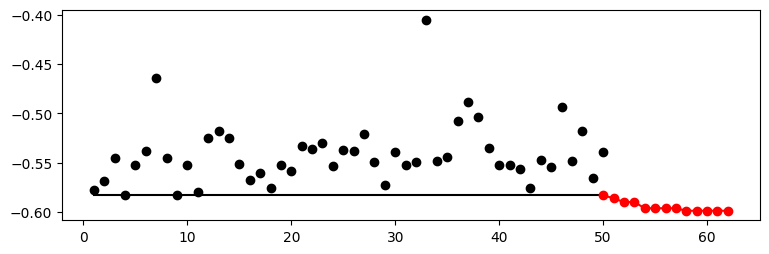

In [31]:
spot_tuner.plot_progress(log_y=False, filename="../Figures.d/" + experiment_name+"_progress.pdf")

# 
* Getting the tuned parameters

In [32]:
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name                     | type   | default   |   lower |   upper |                 tuned | transform              |   importance | stars   |
|--------------------------|--------|-----------|---------|---------|-----------------------|------------------------|--------------|---------|
| n_estimators             | int    | 7         |     5.0 |    10.0 |                   9.0 | transform_power_2_int  |        16.55 | *       |
| criterion                | factor | gini      |     0.0 |     2.0 |                   0.0 | None                   |         0.84 | .       |
| max_depth                | int    | 10        |     1.0 |    20.0 |                   8.0 | transform_power_2_int  |       100.00 | ***     |
| min_samples_split        | int    | 2         |     2.0 |   100.0 |                   4.0 | None                   |         9.01 | *       |
| min_samples_leaf         | int    | 1         |     1.0 |    25.0 |                   4.0 | None                   |         7.21 | * 

# 
* Variable Importance

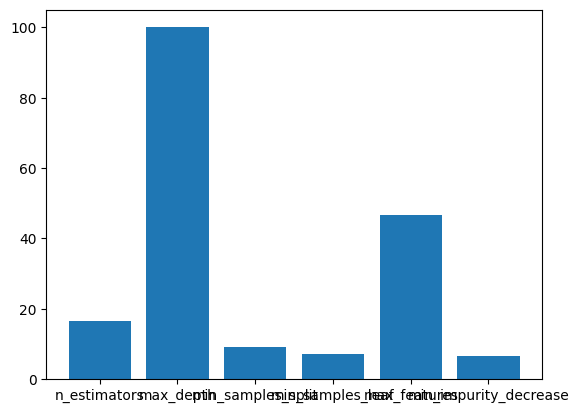

In [33]:
spot_tuner.plot_importance(threshold=1.0, filename="../Figures.d/" + experiment_name+"_importance.pdf")

# 
## 5. Evaluation and Comparison with `default` model

#### Getting default model with default parameters 

In [34]:
values_default = get_default_values(fun_control)
values_default = transform_hyper_parameter_values(fun_control=fun_control, hyper_parameter_values=values_default)
values_default

{'n_estimators': 128,
 'criterion': 'gini',
 'max_depth': 1024,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_features': 'sqrt',
 'max_leaf_nodes': 1024,
 'min_impurity_decrease': 0.0,
 'bootstrap': 1,
 'oob_score': 0}

In [35]:
model_default = make_pipeline(fun_control["prep_model"], fun_control["core_model"](**values_default))
model_default

Pipeline(steps=[('nonetype', None),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=1, max_depth=1024,
                                        max_leaf_nodes=1024, n_estimators=128,
                                        oob_score=0))])

# 
#### Getting tuned parameters and model from `spot`

In [36]:
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
v_dict = assign_values(X, fun_control["var_name"])
return_conf_list_from_var_dict(var_dict=v_dict, fun_control=fun_control)

[{'n_estimators': 512,
  'criterion': 'gini',
  'max_depth': 256,
  'min_samples_split': 4,
  'min_samples_leaf': 4,
  'min_weight_fraction_leaf': 0.01,
  'max_features': 'log2',
  'max_leaf_nodes': 2048,
  'min_impurity_decrease': 0.0015748368906723118,
  'bootstrap': 1,
  'oob_score': 1}]

In [37]:
model_spot = get_one_sklearn_model_from_X(X, fun_control)
model_spot

RandomForestClassifier(bootstrap=1, max_depth=256, max_features='log2',
                       max_leaf_nodes=2048,
                       min_impurity_decrease=0.0015748368906723118,
                       min_samples_leaf=4, min_samples_split=4,
                       min_weight_fraction_leaf=0.01, n_estimators=512,
                       oob_score=1)

# 
#### Fetching `train` and `test` data from `fun_control`

In [38]:
X_train, y_train = get_Xy_from_df(fun_control["train"], fun_control["target_column"])
X_test, y_test = get_Xy_from_df(fun_control["test"], fun_control["target_column"])
X_test.shape, y_test.shape

((177, 10), (177,))

# 
#### One-time `map@k` scores 

The `map@k` scores for **default** and the **tuned** models are calculated only once and compared. However, this is not a definitive metric of model performance.

* `model_spot`

In [39]:
model_spot.fit(X_train, y_train)
y_pred = model_spot.predict_proba(X_test)
res = mapk_score(y_true=y_test, y_pred=y_pred, k=3)
res

0.6007532956685498

* `model_default`

In [40]:
model_default.fit(X_train, y_train)["randomforestclassifier"]
y_pred = model_default.predict_proba(X_test)
mapk_score(y_true=y_test, y_pred=y_pred, k=3)

0.5847457627118644

# 
#### Repeated evaluation on hold-out data 

The `map@k` scores are then calculated `n = 30` times for both the models in order to analyze the min, max and mean scores.

In [41]:
def repeated_eval(n, model):
    res_values = []
    for i in range(n):
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)
        res = mapk_score(y_true=y_test, y_pred=y_pred, k=3)
        res_values.append(res)
    mean_res = np.mean(res_values)
    print(f"mean_res: {mean_res}")
    std_res = np.std(res_values)
    print(f"std_res: {std_res}")
    min_res = np.min(res_values)
    print(f"min_res: {min_res}")
    max_res = np.max(res_values)
    print(f"max_res: {max_res}")
    median_res = np.median(res_values)
    print(f"median_res: {median_res}")
    return mean_res, std_res, min_res, max_res, median_res

* `model_spot`

In [42]:
_ = repeated_eval(30, model_spot)

mean_res: 0.6058694287507848
std_res: 0.004890885694773723
min_res: 0.5932203389830508
max_res: 0.615819209039548
median_res: 0.6059322033898304


* `model_default`

In [43]:
_ = repeated_eval(10, model_default)

mean_res: 0.5942561205273069
std_res: 0.006822032273702421
min_res: 0.5819209039548022
max_res: 0.6054613935969868
median_res: 0.5922787193973635


# 
## 6. Cross-validated Evaluations

The **k-fold Cross Validated** results are a better representative of model performance since the generalized scores over multiple train and test evaluations are considered. 

The evaulations are perfomed for both the model for `trainset`, `testset`, and the whole `train.csv` data.

* `trainset`

In [44]:
from spotPython.sklearn.traintest import evaluate_cv

fun_control.update({
     "eval": "train_cv",
     "k_folds": 10,
})
evaluate_cv(model=model_spot, fun_control=fun_control, verbose=0)

(0.589622641509434, None)

* `testset`

In [45]:
fun_control.update({
     "eval": "test_cv",
     "k_folds": 10,
})
evaluate_cv(model=model_spot, fun_control=fun_control, verbose=0)

(0.57260348583878, None)

* `train.csv`

In [46]:
fun_control.update({
     "eval": "data_cv",
     "k_folds": 10,
})
evaluate_cv(model=model_spot, fun_control=fun_control, verbose=0)

(0.6011535881958416, None)

# 
## 7. Generating Submissions

In [47]:
# test_df = pd.read_csv('./data/Kaggle/test.csv')
# col_id = test_df['id']

# test_df = test_df.astype(int)
# test_df = combine_features(test_df)
# test_df = cluster_features(test_df)
# test_df = affinity_propagation_features(test_df)
# test_df = test_df[rfe_selector.get_feature_names_out()]

# lda1 = joblib.load('lda_model.pkl')
# test_df = pd.DataFrame(lda1.transform(test_df))

# n_features = test_df.shape[1] - 1
# test_df.columns = [f"x{i}" for i in range(1, n_features+2)]

# test_df

In [48]:
# y = model_spot.predict_proba(test_df)

# test_sorted_prediction_ids = np.argsort(-y, axis=1)
# test_top_3_prediction_ids = test_sorted_prediction_ids[:,:3]
# original_shape = test_top_3_prediction_ids.shape
# test_top_3_prediction = enc.inverse_transform(test_top_3_prediction_ids.reshape(-1, 1))
# test_top_3_prediction = test_top_3_prediction.reshape(original_shape)

# test_df['prognosis'] = np.apply_along_axis(lambda x: np.array(' '.join(x), dtype="object"), 1, test_top_3_prediction)

In [49]:
# submission = pd.DataFrame()

# submission['id'] = col_id
# submission['prognosis'] = test_df['prognosis']

# submission.to_csv('./data/submission.csv', index=False)